# Running HMETS on the 5797 basins of the extended CANOPEX dataset

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We also prepare and gather data directly from the CANOPEX dataset made available freely for all users.

In [1]:
# Cookie-cutter template necessary to provide the tools, packages and paths for the project. All notebooks
# need this template (or a slightly adjusted one depending on the required packages)
from birdy import WPSClient

from ravenpy.utilities.testdata import get_file
import datetime as dt
from pathlib import Path
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc
from zipfile import ZipFile
import glob
import tempfile

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)
wps = WPSClient(url)

# DATA MAIN SOURCE - DAP link to CANOPEX dataset
CANOPEX_DAP = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc"
CANOPEX_URL = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/fileServer/birdhouse/ets/Watersheds_5797_cfcompliant.nc"
ds = xr.open_dataset(CANOPEX_DAP)

In [2]:
# SETUP THE RUN PARAMETERS, for now only the start and end years of the simulation and choosing the watershed
start = dt.datetime(1998, 1, 1)
stop = dt.datetime(2010, 12, 31)

# For now, we have no mechanism to link a location (lon, lat) to a given watershed. Let's pick one at random
# from the dataset:
watershedID = 5600

In [3]:
# With this info, we can gather some properties from the CANOPEX database:
tmp = pd.read_csv(get_file("regionalisation_data/gauged_catchment_properties.csv"))
basin_area = tmp["area"][watershedID]
basin_latitude = tmp["latitude"][watershedID]
basin_longitude = tmp["longitude"][watershedID]
basin_elevation = tmp["elevation"][watershedID]
basin_name = ds.watershed[watershedID].data

print("Basin name: ", basin_name)
print("Latitude: ", basin_latitude, " °N")
print("Area: ", basin_area, " km^2")

Basin name:  b'WHITEMOUTH RIVER NEAR WHITEMOUTH'
Latitude:  49.51119663557124  °N
Area:  3650.476384548832  km^2


In [4]:
# Ideally we would be able to pass the DAP link directly to Raven, but there are still some issues
# to fix to be able to do that. For now, we'll download the series at the point of interest.
path = Path(tempfile.mkdtemp()) / "ts.nc"
ts = ds.isel(watershed=watershedID).sel(time=slice(start, stop))
ts.to_netcdf(path)

Now, we might have the model and data, but we don't have model parameters! We need to calibrate. This next snippet shows how to do so.

In [5]:
# The model parameters bounds can either be set independently or we can use the defaults. We will use the defaults,
# but if you wanted to use different values you could pass them as a comma delimited string, as so:
lowerBounds = (
    "0.3, 0.01, 0.5, 0.15, 0.0, 0.0, -2.0, 0.01, 0.0, 0.01, 0.005, -5.0, "
    "0.0, 0.0, 0.0, 0.0, 0.00001, 0.0, 0.00001, 0.0, 0.0"
)
upperBounds = (
    "20.0, 5.0, 13.0, 1.5, 20.0, 20.0, 3.0, 0.2, 0.1, 0.3, 0.1, 2.0, 5.0, "
    "1.0, 3.0, 1.0, 0.02, 0.1, 0.01, 0.5, 2.0"
)

# ... and add them to the config dictionary below by uncommenting the two lines:

# We'll definitely want to adjust the optimization algorithm, random seed and number of model evaluations
algorithm = "DDS"
max_iterations = 50  # This is to keep computing time fast for the demo, you should definitely increase this to a few hundreds or thousands.
random_seed = (
    1,
)  # This is to allow reproduction. If it is left uncommented in the configuration below, the results will always be the same. Therefore it should always be commented except for debugging cases

# We will also calibrate on only a subset of the years for now to keep the computations faster in this notebook.
start_calib = dt.datetime(1998, 1, 1)
end_calib = dt.datetime(1999, 12, 31)

# Model configuration parameters
config = dict(
    start_date=start_calib,
    end_date=end_calib,
    area=basin_area,
    elevation=basin_elevation,
    # upperBounds=upperBounds,
    # lowerBounds=lowerBounds,
    random_seed=random_seed,
    algorithm=algorithm,
    max_iterations=max_iterations,
    latitude=basin_latitude,
    longitude=basin_longitude,
    suppress_output=True,  # This will make raven much faster as it will not write the model outputs to file after each evaluation.
    run_name="test_hmets_NRCAN",
    rain_snow_fraction="RAINSNOW_DINGMAN",
    nc_spec=json.dumps(
        {
            "tasmax": {"offset": -273.15},
            "tasmin": {"offset": -273.15},
            "pr": {"scale": 86400.0},
        },
    ),  # This allows transforming and scaling units for Raven
)

# Let's call the model with the timeseries (meteorological and observed streamflow for calibration!),
# model parameters and other configuration parameters
resp = wps.ostrich_hmets(ts=str(path), **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[calibration, hydrograph, storage, solution, diagnostics, calibparams, rv] = resp.get(
    asobj=True
)

In [6]:
# We can see the calibrated parameters:
print(calibparams)

14.84182, 0.06444441, 9.056403, 1.474334, 10.06818, 15.33386, 2.105304, 0.0629425, 0.04687986, 0.2330103, 0.08535756, 0.4835641, 3.836542, 0.8082868, 2.463173, 0.9814977, 0.01988597, 0.004307281, 0.005753699, 168.25789999999998, 67.11683000000001


In [7]:
# And also the NSE value:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH_ALL,/tmp/pywps_process_toq9iq7b/input.nc,0.0886072,24.1576,



At this stage, we have calibrated the model on the observations for the desired dates. Now, let's run the model on a longer time period and look at the hydrograph

In [8]:
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple.
# Here we will use the calibrated parameters, but we could overwrite them with our own parameters as so:

# calibparams = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
#               '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'

# Model configuration parameters
config = dict(
    start_date=start,
    end_date=stop,
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name="test_hmets_NRCAN",
    rain_snow_fraction="RAINSNOW_DINGMAN",
    nc_spec=json.dumps(
        {
            "tasmax": {"offset": -273.15},
            "tasmin": {"offset": -273.15},
            "pr": {"scale": 86400.0},
        },
    ),
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(path), params=calibparams, nc_index=watershedID, **config)

In [9]:
# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The diagnostics is just a CSV file:

In [10]:
# We can analyze and plot the data directly here to see what it looks like, or we could download the data directly by
# changing the asobj=True to asobj=False in the cell above this one.
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH_ALL,/tmp/pywps_process_bp6z6vom/input.nc,-0.00365238,28.8105,



In [11]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH_ALL,/tmp/pywps_process_bp6z6vom/input.nc,-0.00365238,28.8105,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools.

In [12]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 4748, nbasins: 1)>
array([[ 0.      ],
       [11.936645],
       [23.861701],
       ...,
       [13.899536],
       [14.810014],
       [12.807957]])
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2010-12-31
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

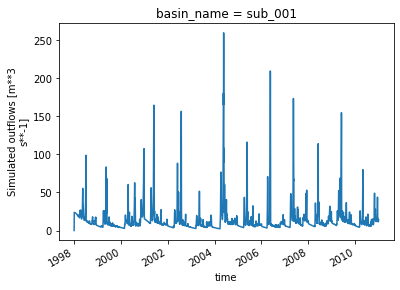

In [13]:
# Plot the simulated hydrograph
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
hydrograph.q_sim.plot()

In [14]:
# You can also get statistics from the data directly here.
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print(
    "Monthly means: ",
    hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim="time"),
)

Max:  <xarray.DataArray 'q_sim' ()>
array(259.95939439)
Mean:  <xarray.DataArray 'q_sim' ()>
array(13.58407278)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[ 7.65032172],
       [ 6.63937407],
       [ 8.6459087 ],
       [20.31188009],
       [35.38097472],
       [16.70298779],
       [14.38227892],
       [10.20047481],
       [ 8.32604189],
       [ 9.72928757],
       [11.78167964],
       [12.72717387]])
Coordinates:
    basin_name  (nbasins) object 'sub_001'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins


For an example of how to download the data directly to analyze locally on your own computer/server, see here:

In [15]:
# Rerun the analysis of the WPS response, this type by using asobj=False.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=False)
print(hydrograph)
print(storage)
print(solution)
print(diagnostics)
print(rv)

https://pavics.ouranos.ca/wpsoutputs/8803ba38-10e4-11ec-af5b-a44cc85b43bf/test_hmets_NRCAN-0_Hydrographs.nc
https://pavics.ouranos.ca/wpsoutputs/8803ba38-10e4-11ec-af5b-a44cc85b43bf/test_hmets_NRCAN-0_WatershedStorage.nc
https://pavics.ouranos.ca/wpsoutputs/8803ba38-10e4-11ec-af5b-a44cc85b43bf/test_hmets_NRCAN-0_solution.rvc
https://pavics.ouranos.ca/wpsoutputs/8803ba38-10e4-11ec-af5b-a44cc85b43bf/test_hmets_NRCAN-0_Diagnostics.csv
https://pavics.ouranos.ca/wpsoutputs/8803ba38-10e4-11ec-af5b-a44cc85b43bf/rv.zip
